In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import centroid

from tifffile import imread, TiffFile

In [30]:
# img = imread('W1_Levi_40x_1_Conf488.stk')

# spacing = np.array([200, 163, 163])

In [4232]:
file_name = '/Users/lgelman/Desktop/Singlebeads/LFOV_Dots_LowSNR_scale1-4.tif'
factor = 1
tiff = TiffFile(file_name)

In [4233]:
zres = tiff.imagej_metadata['spacing'] * 1000

In [4234]:
xres = 1e9/tiff.pages[0].tags[282].value[0]
yres = 1e9/tiff.pages[0].tags[283].value[0]

In [4235]:
img = tiff.asarray()

spacing = np.array([zres*factor, yres*factor, xres*factor])
print(spacing)

[99.23076923 40.         40.        ]


In [4236]:
def get_raw_crop(img, size_nm, spacing):
    z, y, x = np.unravel_index(np.argmax(img), img.shape)
    
    half_size = np.ceil(size_nm / spacing / 2).astype(int)
    
    z_slice = slice(max(0, z - half_size[0]*2), min(z + half_size[0]*2 + 1, img.shape[0]))
    y_slice = slice(max(0, y - half_size[1]), min(y + half_size[1] + 1, img.shape[1]))
    x_slice = slice(max(0, x - half_size[2]), min(x + half_size[2] + 1, img.shape[2]))
    
    
    crop = img[z_slice, y_slice, x_slice]
    return crop

In [4237]:
# img = imread('XY266_Z622_simulated.tif')
# img = np.random.poisson(img*500) # Add some noise

# spacing = np.array([100, 40, 40])

In [4238]:
psf = get_raw_crop(img, 2000, spacing)

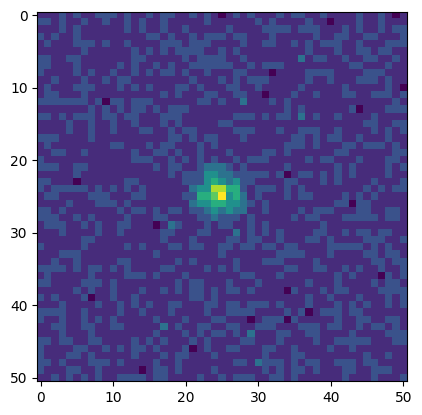

In [4239]:
plt.imshow(psf[psf.shape[0]//2])

In [4240]:
y_lim = [0, psf.max() * 1.1]

In [4241]:
def get_cov_matrix(img, spacing):
    def cov(x, y, i):
        return np.sum(x * y * i) / np.sum(i)

    extends = [np.arange(l) * s for l, s in zip(img.shape, spacing)]
    
    grids = np.meshgrid(
        *extends,
        indexing="ij",
    )
    cen = centroid(img)
    
    if img.ndim == 1:
        x = grids[0].ravel() - cen[0] * spacing[0]
        return cov(x, x, img.ravel())
    elif img.ndim == 2:
        y = grids[0].ravel() - cen[0] * spacing[0]
        x = grids[1].ravel() - cen[1] * spacing[1]

        cxx = cov(x, x, img.ravel())
        cyy = cov(y, y, img.ravel())
        cxy = cov(x, y, img.ravel())

        return np.array([[cxx, cxy], [cxy, cyy]])
    elif img.ndim == 3:
        z = grids[0].ravel() - cen[0] * spacing[0]
        y = grids[1].ravel() - cen[1] * spacing[1]
        x = grids[2].ravel() - cen[2] * spacing[2]

        cxx = cov(x, x, img.ravel())
        cyy = cov(y, y, img.ravel())
        czz = cov(z, z, img.ravel())
        cxy = cov(x, y, img.ravel())
        cxz = cov(x, z, img.ravel())
        cyz = cov(y, z, img.ravel())

        return np.array([[cxx, cxy, cxz], [cxy, cyy, cyz], [cxz, cyz, czz]])
    else:
        NotImplementedError()

In [4242]:
def fwhm(sigma):
    return 2 * np.sqrt(2 * np.log(2)) * sigma

In [4243]:
def plot_fit_1d(psf1d, coords, params, prefix, ylim=[0, 9200]):
    fine_coords = np.linspace(coords[0], coords[-1], 500)
    plt.plot(coords, psf1d, '-', label='measurment', color='k')
    plt.bar(coords, psf1d, width=15, color='k')
    plt.plot(coords, [params[1],] * len(coords), '--', label=f'{prefix} background' )
    plt.plot(coords, [params[1] + params[0],] * len(coords), '--', label=f'{prefix} amplitude')
    plt.plot([params[2],]* 2, [params[1], params[1] + params[0]], '--', label=f'{prefix} location')
    plt.plot(fine_coords, gauss_1d(*params)(fine_coords), '--', label=f'{prefix} Gaussian')
    plt.ylim(ylim)
    plt.legend();

# 1D fits

## X

In [4244]:
psf_x = psf[psf.shape[0]//2, psf.shape[1]//2]

In [4245]:
coords_x = np.arange(len(psf_x)) * spacing[2]

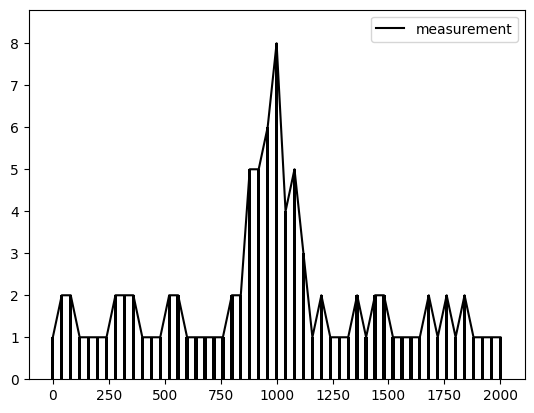

In [4246]:
plt.plot(coords_x, psf_x, '-', label='measurement', color='k')
plt.bar(coords_x, psf_x, width=15, color='k')
plt.ylim(y_lim)
plt.legend();

### Estimate from data

In [4247]:
def gauss_1d(amp, bg, mu, sigma):
    return lambda x: amp * np.exp(-(x - mu)**2 / (2*sigma**2)) + bg

In [4248]:
bg = np.median(psf_x)
amp = psf_x.max() - bg
sigma = np.sqrt(get_cov_matrix(np.clip(psf_x - bg, 0, psf_x.max()), [spacing[2]]))
mu = centroid(psf_x) * spacing[2]

plot_fit_1d(psf_x, coords_x, [amp, bg, mu, sigma], "Est.", y_lim)

### Curve fit least squares

In [4249]:
from scipy.optimize import curve_fit

In [4250]:
def eval_fun(x, amp, bg, mu, sigma):
    return gauss_1d(amp=amp, bg=bg, mu=mu, sigma=sigma)(x)

In [4251]:
params = [amp, bg, mu[0], sigma]

In [4252]:
try:
    popt, pcov = curve_fit(
        eval_fun,
        coords_x,
        psf_x,
        p0=params,
    )
except RuntimeError as e:
    popt = np.array([0, ] * len(params))

In [4253]:
popt

array([  5.43682386,   1.32254863, 981.60688843, -83.79752797])

fine_coords_x = np.linspace(coords_x[0], coords_x[-1], 500)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_fit_1d(psf_x, coords_x, params, "Est.", y_lim)
plt.title('Estimated from data');
plt.subplot(1,2,2)
plot_fit_1d(psf_x, coords_x, popt, "Curve fit", y_lim)
plt.title('Curve fit');

### Minimize Kullback-Leibler Divergence

In [4254]:
from scipy.special import kl_div
from scipy.optimize import minimize

def get_objective(coords, measurement):
    def objective(params):

        
        fit = gauss_1d(*params)(coords)
        
        kld = kl_div(fit, measurement)
        kld[np.isinf(kld)] = 0
        
        return np.sum(kld)
    
    return objective

In [4255]:
res = minimize(get_objective(coords_x, psf_x), 
               x0=params,
               method='L-BFGS-B', 
               options={'disp': True},
               bounds=[
                   (params[0]/2, params[0]*2), 
                   (0, params[0]/2), 
                   (params[2] - params[3] / 2, params[2] + params[3] / 2), 
                   (spacing[1]/4, 2*params[3])]
              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31708D+01    |proj g|=  3.50000D+00

At iterate    1    f=  2.50363D+01    |proj g|=  3.50000D+00

At iterate    2    f=  2.11062D+01    |proj g|=  4.02800D-01

At iterate    3    f=  2.10992D+01    |proj g|=  2.59175D-01

At iterate    4    f=  2.10984D+01    |proj g|=  1.97055D-02

At iterate    5    f=  2.10982D+01    |proj g|=  3.19442D-02

At iterate    6    f=  2.10967D+01    |proj g|=  2.17112D-01

At iterate    7    f=  2.10930D+01    |proj g|=  3.96647D-01

At iterate    8    f=  2.10829D+01    |proj g|=  4.11209D-01

At iterate    9    f=  2.10557D+01    |proj g|=  4.40093D-01

At iterate   10    f=  2.09739D+01    |proj g|=  5.08199D-01

At iterate   11    f=  2.06545D+01    |proj g|=  7.24029D-01

At iterate   12    f=  1.95797D+01    |proj g|=  1.33521D+00
  Positive dir derivative i

fine_coords_x = np.linspace(coords_x[0], coords_x[-1], 500)
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_fit_1d(psf_x, coords_x, [amp, bg, mu, sigma], "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(2,2,2)
plot_fit_1d(psf_x, coords_x, popt, "Curve fit", y_lim)
plt.title('Curve fit');

plt.subplot(2,2,3)
plot_fit_1d(psf_x, coords_x, res.x, "KL-Div", y_lim)
plt.title('Minimize KL-Div');

In [4256]:
est_fwhm_x = fwhm(sigma)
cv_fwhm_x = fwhm(popt[3])
kld_fwhm_x = fwhm(res.x[3])

In [4257]:
mu_x = res.x[2]
amp_x = res.x[0]
bg_x = res.x[1]

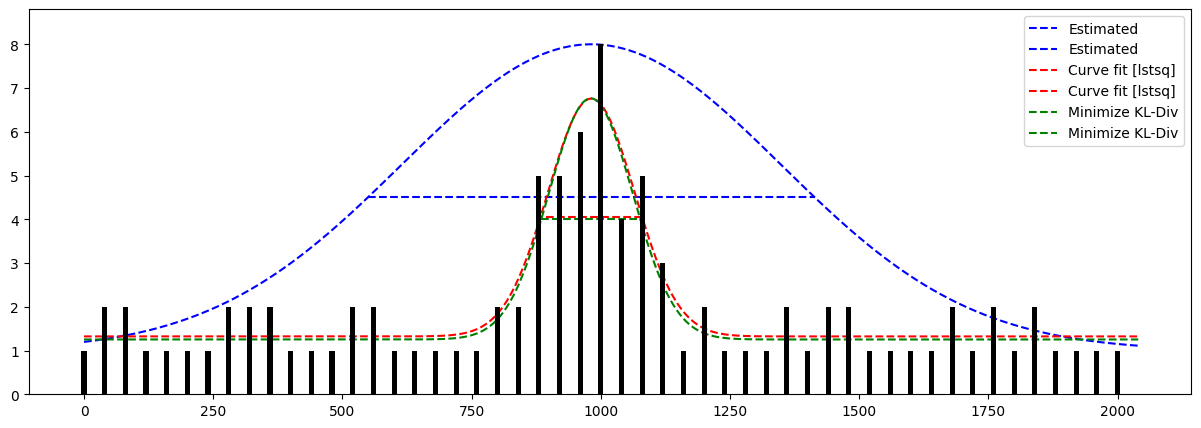

In [4258]:
# plt.plot(coords_x, psf_x, '-', label='measurment', color='gray', linewidth=2, zorder=10)
plt.figure(figsize=(15,5))
plt.bar(coords_x, psf_x, width=10, color='k', zorder=10)
plt.plot(fine_coords_x, gauss_1d(amp, bg, mu[0], sigma)(fine_coords_x), '--', label='Estimated', color='b')
plt.plot([mu[0] - est_fwhm_x / 2, mu[0] + est_fwhm_x / 2], [bg + amp/2 , ]* 2, '--', color='b')
plt.plot(fine_coords_x, gauss_1d(*popt)(fine_coords_x), '--', label='Curve fit [lstsq]', color='r')
plt.plot([popt[2] - cv_fwhm_x / 2, popt[2] + cv_fwhm_x / 2], [popt[1] + popt[0]/2 , ]* 2, '--', color='r')
plt.plot(fine_coords_x, gauss_1d(*res.x)(fine_coords_x), '--', label='Minimize KL-Div', color='g')
plt.plot([res.x[2] - kld_fwhm_x / 2, res.x[2] + kld_fwhm_x / 2], [res.x[1] + res.x[0]/2 , ]* 2, '--', color='g')
plt.ylim(y_lim)
plt.legend();

In [4259]:
print(f"Estimated FWHM: {est_fwhm_x:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_x:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_x:.4f}")

Estimated FWHM: 864.7720
Curve fit FWHM: -197.3281
Min. KL-D FWHM: 190.9475


In [4260]:
def mse(params, coords, target):
    return np.mean((target - gauss_1d(*params)(coords))**2)

In [4261]:
def mae(params, coords, target):
    return np.mean(np.abs(target - gauss_1d(*params)(coords)))

In [4262]:
def kl_div_error(params, coords, target):
    return get_objective(coords, target)(params)

In [4263]:
print("Mean Squared Error")
print(f"Estimated: {mse([amp, bg, mu[0], sigma], coords_x, psf_x):.3f}")
print(f"Curve fit: {mse(popt, coords_x, psf_x):.3f}")
print(f"Min. KL-D: {mse(res.x, coords_x, psf_x):.3f}")

Mean Squared Error
Estimated: 9.111
Curve fit: 0.343
Min. KL-D: 0.351


In [4264]:
print("Mean Absolute Error")
print(f"Estimated: {mae([amp, bg, mu[0], sigma], coords_x, psf_x):.3f}")
print(f"Curve fit: {mae(popt, coords_x, psf_x):.3f}")
print(f"Min. KL-D: {mae(res.x, coords_x, psf_x):.3f}")

Mean Absolute Error
Estimated: 2.345
Curve fit: 0.515
Min. KL-D: 0.501


In [4265]:
print("Kullback-Leibler Divergence")
print(f"Estimated: {kl_div_error([amp, bg, mu[0], sigma], coords_x, psf_x):.3f}")
print(f"Curve fit: {kl_div_error(popt, coords_x, psf_x):.3f}")
print(f"Min. KL-D: {kl_div_error(res.x, coords_x, psf_x):.3f}")

Kullback-Leibler Divergence
Estimated: 93.171
Curve fit: 4.220
Min. KL-D: 4.101


## Y

In [4266]:
psf_y = psf[psf.shape[0]//2, :, psf.shape[2]//2]

In [4267]:
coords_y = np.arange(len(psf_y)) * spacing[1]

plt.plot(coords_y, psf_y, '-', label='measurment', color='k')
plt.bar(coords_y, psf_y, width=15, color='k')
plt.ylim(y_lim)
plt.legend();

### Estimate from data

In [4268]:
bg = np.median(psf_y)
amp = psf_y.max() - bg
sigma = np.sqrt(get_cov_matrix(np.clip(psf_y - bg, 0, psf_y.max()), [spacing[1]]))
mu = centroid(psf_y) * spacing[1]

plot_fit_1d(psf_y, coords_y, [amp, bg, mu, sigma], "Est.", y_lim)

### Curve fit least squares

In [4269]:
params = [amp, bg, mu[0], sigma]

In [4270]:
popt, pcov = curve_fit(
    eval_fun,
    coords_y,
    psf_y,
    p0=params,
)

In [4271]:
popt

array([  6.26598328,   1.32815323, 985.88517379, -59.24731492])

fine_coords_x = np.linspace(coords_x[0], coords_x[-1], 500)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_fit_1d(psf_y, coords_y, params, "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(1,2,2)
plot_fit_1d(psf_y, coords_y, popt, "Curve fit", y_lim)
plt.title('Curve fit');

### Minimize KL-Div

In [4272]:
res = minimize(get_objective(coords_y, psf_y), 
               x0=params,
               method='L-BFGS-B', 
               options={'disp': True},
               bounds=[
                   (params[0]/2, params[0]*2), 
                   (0, params[0]/2), 
                   (params[2] - params[3] / 2, params[2] + params[3] / 2), 
                   (spacing[1]/4, 2*params[3])]
              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02201D+02    |proj g|=  3.50000D+00

At iterate    1    f=  2.36927D+01    |proj g|=  3.50000D+00

At iterate    2    f=  2.15269D+01    |proj g|=  3.15680D-01

At iterate    3    f=  2.15124D+01    |proj g|=  2.90662D-01

At iterate    4    f=  2.15114D+01    |proj g|=  1.32758D-02

At iterate    5    f=  2.15114D+01    |proj g|=  1.32957D-02

At iterate    6    f=  2.15113D+01    |proj g|=  3.41494D-02

At iterate    7    f=  2.15112D+01    |proj g|=  7.44222D-02

At iterate    8    f=  2.15110D+01    |proj g|=  1.49941D-01

At iterate    9    f=  2.15103D+01    |proj g|=  2.65982D-01

At iterate   10    f=  2.15085D+01    |proj g|=  3.01044D-01

At iterate   11    f=  2.15039D+01    |proj g|=  3.11211D-01

At iterate   12    f=  2.14909D+01    |proj g|=  3.31933D-01

At iterate   13    f=  2.1

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_fit_1d(psf_y, coords_y, [amp, bg, mu, sigma], "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(2,2,2)
plot_fit_1d(psf_y, coords_y, popt, "Curve fit", y_lim)
plt.title('Curve fit');

plt.subplot(2,2,3)
plot_fit_1d(psf_y, coords_y, res.x, "KL-Div", y_lim)
plt.title('Minimize KL-Div');

In [4273]:
est_fwhm_y = fwhm(sigma)
cv_fwhm_y = fwhm(popt[3])
kld_fwhm_y = fwhm(res.x[3])

In [4274]:
mu_y = res.x[2]
amp_y = res.x[0]
bg_y = res.x[1]

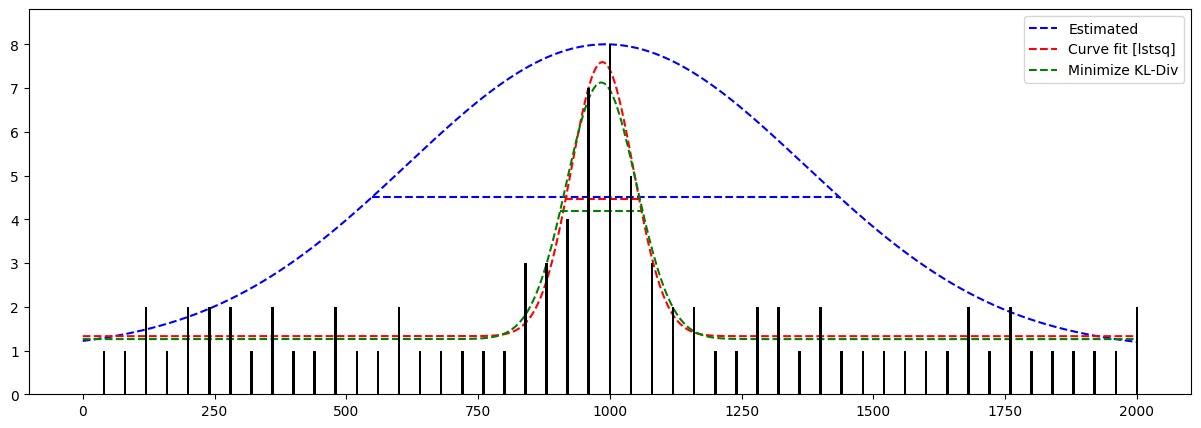

In [4275]:
fine_coords_y = np.linspace(coords_y[0], coords_y[-1], 500)
# plt.plot(coords_x, psf_x, '-', label='measurment', color='gray', linewidth=2, zorder=10)
plt.figure(figsize=(15,5))
plt.bar(coords_y, psf_y, width=5, color='k', zorder=10)
plt.plot(fine_coords_y, gauss_1d(amp, bg, mu[0], sigma)(fine_coords_y), '--', label='Estimated', color='b')
plt.plot([mu[0] - est_fwhm_y / 2, mu[0] + est_fwhm_y / 2], [bg + amp/2 , ]* 2, '--', color='b')
plt.plot(fine_coords_y, gauss_1d(*popt)(fine_coords_y), '--', label='Curve fit [lstsq]', color='r')
plt.plot([popt[2] - cv_fwhm_y / 2, popt[2] + cv_fwhm_y / 2], [popt[1] + popt[0]/2 , ]* 2, '--', color='r')
plt.plot(fine_coords_y, gauss_1d(*res.x)(fine_coords_y), '--', label='Minimize KL-Div', color='g')
plt.plot([res.x[2] - kld_fwhm_y / 2, res.x[2] + kld_fwhm_y / 2], [res.x[1] + res.x[0]/2 , ]* 2, '--', color='g')
plt.ylim(y_lim)
plt.legend();

In [4276]:
print("X")
print(f"Estimated FWHM: {est_fwhm_x:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_x:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_x:.4f}")

X
Estimated FWHM: 864.7720
Curve fit FWHM: -197.3281
Min. KL-D FWHM: 190.9475


In [4277]:
print("Y")
print(f"Estimated FWHM: {est_fwhm_y:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_y:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_y:.4f}")

Y
Estimated FWHM: 887.7485
Curve fit FWHM: -139.5168
Min. KL-D FWHM: 156.3559


In [4278]:
print("Mean Squared Error")
print(f"Estimated: {mse([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mse(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mse(res.x, coords_y, psf_y):.3f}")

Mean Squared Error
Estimated: 10.120
Curve fit: 0.278
Min. KL-D: 0.288


In [4279]:
print("Mean Absolute Error")
print(f"Estimated: {mae([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mae(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mae(res.x, coords_y, psf_y):.3f}")

Mean Absolute Error
Estimated: 2.504
Curve fit: 0.465
Min. KL-D: 0.452


In [4280]:
print("Kullback-Leibler Divergence")
print(f"Estimated: {kl_div_error([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {kl_div_error(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {kl_div_error(res.x, coords_y, psf_y):.3f}")

Kullback-Leibler Divergence
Estimated: 102.201
Curve fit: 3.661
Min. KL-D: 3.543


## Z

In [4281]:
psf_z = psf[:, psf.shape[1]//2, psf.shape[2]//2]

In [4282]:
coords_z = np.arange(len(psf_z)) * spacing[0]

plt.plot(coords_z, psf_z, '-', label='measurement', color='k')
plt.bar(coords_z, psf_z, width=15, color='k')
plt.ylim(y_lim)
plt.legend();

### Estimate from data

In [4283]:
bg = np.median(psf_z)
amp = psf_z.max() - bg
sigma = np.sqrt(get_cov_matrix(np.clip(psf_z - bg, 0, psf_z.max()), [spacing[0]]))
mu = centroid(psf_z) * spacing[0]

plot_fit_1d(psf_z, coords_z, [amp, bg, mu, sigma], "Est.", y_lim)

### Curve fit least squares

In [4284]:
params = [amp, bg, mu[0], sigma]

In [4285]:
popt, pcov = curve_fit(
    eval_fun,
    coords_z,
    psf_z,
    p0=params,
)

In [4286]:
popt

array([5.00205342e+00, 1.36387369e+00, 2.07188319e+03, 3.37349026e+02])

fine_coords_z = np.linspace(coords_z[0], coords_z[-1], 500)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_fit_1d(psf_z, coords_z, params, "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(1,2,2)
plot_fit_1d(psf_z, coords_z, popt, "Curve fit", y_lim)
plt.title('Curve fit');

### Minimize KL-Div

In [4287]:
res = minimize(get_objective(coords_z, psf_z), 
               x0=params,
               method='L-BFGS-B', 
               options={'disp': True},
               bounds=[
                   (params[0]/2, params[0]*2), 
                   (0, params[0]/2), 
                   (params[2] - params[3] / 2, params[2] + params[3] / 2), 
                   (spacing[1]/4, 2*params[3])]
              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29677D+01    |proj g|=  3.00000D+00

At iterate    1    f=  7.10148D+00    |proj g|=  1.21079D+00

At iterate    2    f=  7.00805D+00    |proj g|=  9.69582D-01

At iterate    3    f=  6.78550D+00    |proj g|=  2.10318D-01

At iterate    4    f=  6.78443D+00    |proj g|=  6.06840D-02

At iterate    5    f=  6.78436D+00    |proj g|=  1.68393D-02

At iterate    6    f=  6.78432D+00    |proj g|=  1.68105D-02

At iterate    7    f=  6.78409D+00    |proj g|=  5.79640D-02

At iterate    8    f=  6.78363D+00    |proj g|=  1.29142D-01

At iterate    9    f=  6.78227D+00    |proj g|=  2.58393D-01

At iterate   10    f=  6.77886D+00    |proj g|=  4.59072D-01

At iterate   11    f=  6.76979D+00    |proj g|=  7.89112D-01

At iterate   12    f=  6.74626D+00    |proj g|=  1.31740D+00

At iterate   13    f=  6.6

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_fit_1d(psf_z, coords_z, params, "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(2,2,2)
plot_fit_1d(psf_z, coords_z, popt, "Curve fit", y_lim)
plt.title('Curve fit');

plt.subplot(2,2,3)
plot_fit_1d(psf_z, coords_z, res.x, "KL-Div", y_lim)
plt.title('Minimize KL-Div');

In [4288]:
est_fwhm_z = fwhm(sigma)
cv_fwhm_z = fwhm(popt[3])
kld_fwhm_z = fwhm(res.x[3])

In [4289]:
mu_z = res.x[2]
amp_z = res.x[0]
bg_z = res.x[1]

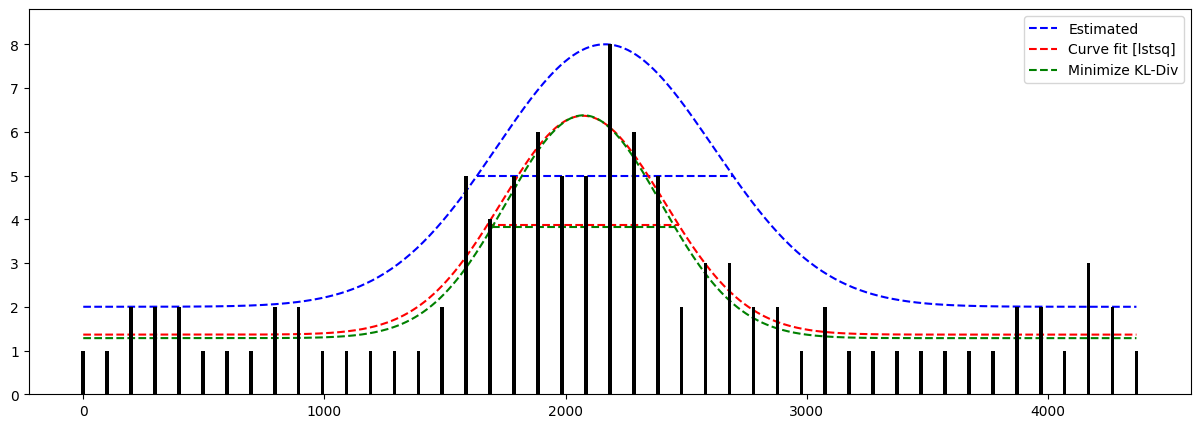

In [4290]:
plt.figure(figsize=(15,5))
fine_coords_z = np.linspace(coords_z[0], coords_z[-1], 500)
# plt.plot(coords_x, psf_x, '-', label='measurment', color='gray', linewidth=2, zorder=10)
plt.bar(coords_z, psf_z, width=15, color='k', zorder=10)

plt.plot(fine_coords_z, gauss_1d(amp, bg, mu[0], sigma)(fine_coords_z), '--', label='Estimated', color='b')
plt.plot([mu[0] - est_fwhm_z / 2, mu[0] + est_fwhm_z / 2], [bg + amp/2 , ]* 2, '--', color='b')
plt.plot(fine_coords_z, gauss_1d(*popt)(fine_coords_z), '--', label='Curve fit [lstsq]', color='r')
plt.plot([popt[2] - cv_fwhm_z / 2, popt[2] + cv_fwhm_z / 2], [popt[1] + popt[0]/2 , ]* 2, '--', color='r')
plt.plot(fine_coords_z, gauss_1d(*res.x)(fine_coords_z), '--', label='Minimize KL-Div', color='g')
plt.plot([res.x[2] - kld_fwhm_z / 2, res.x[2] + kld_fwhm_z / 2], [res.x[1] + res.x[0]/2 , ]* 2, '--', color='g')
plt.ylim(y_lim)
plt.legend();

In [4291]:
print("Z")
print(f"Estimated FWHM: {est_fwhm_z:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_z:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_z:.4f}")

Z
Estimated FWHM: 1060.0849
Curve fit FWHM: 794.3962
Min. KL-D FWHM: 755.6695


In [4292]:
print("Mean Squared Error")
print(f"Estimated: {mse([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mse(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mse(res.x, coords_y, psf_y):.3f}")

Mean Squared Error
Estimated: 8.351
Curve fit: 5.451
Min. KL-D: 5.293


In [4293]:
print("Mean Absolute Error")
print(f"Estimated: {mae([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mae(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mae(res.x, coords_y, psf_y):.3f}")

Mean Absolute Error
Estimated: 2.155
Curve fit: 1.638
Min. KL-D: 1.594


In [4294]:
print("Kullback-Leibler Divergence")
print(f"Estimated: {kl_div_error([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {kl_div_error(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {kl_div_error(res.x, coords_y, psf_y):.3f}")

Kullback-Leibler Divergence
Estimated: 86.391
Curve fit: 54.401
Min. KL-D: 52.207


In [4295]:
print("                        X             Y             Z")
print(f"Estimated:      {est_fwhm_x:4.4f}     {est_fwhm_y:4.4f}     {est_fwhm_z:4.4f}")
print(f"Curve fit:      {cv_fwhm_x:4.4f}     {cv_fwhm_y:4.4f}     {cv_fwhm_z:4.4f}")
print(f"Min. KL-D:      {kld_fwhm_x:4.4f}     {kld_fwhm_y:4.4f}     {kld_fwhm_z:4.4f}")

                        X             Y             Z
Estimated:      864.7720     887.7485     1060.0849
Curve fit:      -197.3281     -139.5168     794.3962
Min. KL-D:      190.9475     156.3559     755.6695


# 2D [XY]

In [4296]:
psf_yx = psf[psf.shape[0]//2]

In [4297]:
yy = np.arange(psf_yx.shape[0]) * spacing[1]
xx = np.arange(psf_yx.shape[1]) * spacing[2]
y, x = np.meshgrid(yy, xx, indexing="ij")
coords_yx = np.stack([y.ravel(), x.ravel()], -1)

In [4298]:
yy_fine = np.linspace(0, psf_yx.shape[0], 500) * spacing[1]
xx_fine = np.linspace(0, psf_yx.shape[1], 500) * spacing[2]
y_fine, x_fine = np.meshgrid(yy_fine, xx_fine, indexing="ij")
fine_coords_yx = np.stack([y_fine.ravel(), x_fine.ravel()], -1)

fine_coords_y = np.stack([yy_fine, [xx_fine[xx_fine.shape[0]//2],]*len(yy_fine)], axis=1)
fine_coords_x = np.stack([[yy_fine[yy_fine.shape[0]//2],]*len(xx_fine), xx_fine], axis=1)

plt.imshow(psf_yx)

In [4299]:
def gauss_2d(amp, bg, mu_x, mu_y, cxx, cxy, cyy):
    def fun(coords):
        cov_inv = np.linalg.inv(np.array([[cxx, cxy], [cxy, cyy]]))
        exponent = -0.5 * (cov_inv[0,0] * (coords[:, 1] - mu_x) ** 2
                           + 2 * cov_inv[0, 1] * (coords[:, 1] - mu_x) * (coords[:, 0] - mu_y)
                           + cov_inv[1, 1] * (coords[:, 0] - mu_y) ** 2
            )
        
        return amp * np.exp(exponent) + bg
    return fun

In [4300]:
def show_2d_fit(psf, fit):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(psf)
    plt.subplot(1,2,2)
    plt.imshow(fit)
    plt.show()

### Curve fit least squares

In [4301]:
from scipy.optimize import curve_fit

In [4302]:
def eval_fun(x, amp, bg, mu_x, mu_y, cxx, cxy, cyy):
    return gauss_2d(amp=amp, bg=bg, mu_x=mu_x, mu_y=mu_y, cxx=cxx, cxy=cxy, cyy=cyy)(x)

In [4303]:
bg = np.median(psf_yx)
amp = psf_yx.max() - bg

In [4304]:
params = [
        amp, 
        bg, 
        mu_x, 
        mu_y, 
        (kld_fwhm_x/(2 * np.sqrt(2 * np.log(2))))**2,
        0,
        (kld_fwhm_y/(2 * np.sqrt(2 * np.log(2))))**2
    ]

In [4305]:
try:
    popt, pcov = curve_fit(
        eval_fun,
        coords_yx,
        psf_yx.ravel(),
        p0=params,
    )
except RuntimeError as e:
    popt = np.array([1e-6, 1e-6, 0, 0, 1, 0, 1])

In [4306]:
popt

array([5.32858684e+00, 1.34582670e+00, 9.84193107e+02, 9.84346858e+02,
       6.99349693e+03, 4.51937330e+02, 5.84963683e+03])

In [4307]:
from copy import copy
cv_2d_params = copy(popt)

In [4308]:
cv_2d = gauss_2d(*popt)(fine_coords_yx)
cv_2d = cv_2d.reshape((500, 500))

show_2d_fit(psf_yx, cv_2d)

center = np.array(psf_yx.shape)//2
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(coords_y, psf_yx[:, center[1]], '-', label='measurment', color='k', linewidth=2, zorder=10)
plt.bar(coords_y, psf_yx[:, center[1]], color='k', zorder=10, width=10)
plt.plot(fine_coords_y[:,0], gauss_2d(*params)(fine_coords_y), label="1D KL-Div Fits")
plt.plot(fine_coords_y[:,0], gauss_2d(*popt)(fine_coords_y), label="2D Curve Fit [lstsq]")
plt.ylim(y_lim);
plt.legend();
plt.subplot(1,2,2)
plt.plot(coords_x, psf_yx[center[0]], '-', label='measurment', color='k', linewidth=2, zorder=10)
plt.bar(coords_x, psf_yx[center[0]], color='k', zorder=10, width=10)
plt.plot(fine_coords_x[:,1], gauss_2d(*params)(fine_coords_x), label="1D KL-Div Fits")
plt.plot(fine_coords_x[:,1], gauss_2d(*popt)(fine_coords_x), label="2D Curve Fit [lstsq]")
plt.ylim(y_lim);
plt.legend()

### Minimize KL-Div

In [4309]:
from scipy.special import kl_div
from scipy.optimize import minimize

def get_objective(coords, measurement):
    def objective(params):

        
        fit = gauss_2d(*params)(coords)
        
        kld = kl_div(fit, measurement)
        kld[np.isinf(kld)] = 0
        
        return np.sum(kld)
    
    return objective

In [4310]:
res = minimize(get_objective(coords_yx, psf_yx.ravel()), 
               x0=params,
               method='L-BFGS-B',
               options={'disp': True},
               bounds=[
                   (params[0]*0.5, params[0]*1.5), 
                   (0, params[0]/2), 
                   (params[2] - spacing[2], params[2] + spacing[2]), 
                   (params[3] - spacing[1], params[3] + spacing[1]), 
                   (params[4]*0.5, params[4]*1.5),
                   (None, None),
                   (params[6]*0.5, params[6]*1.5),
               ]
              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85854D+02    |proj g|=  2.50000D+00

At iterate    1    f=  2.02488D+02    |proj g|=  2.16864D+00

At iterate    2    f=  2.02457D+02    |proj g|=  2.14199D+00

At iterate    3    f=  2.02454D+02    |proj g|=  2.13495D+00

At iterate    4    f=  2.02445D+02    |proj g|=  2.22295D+00

At iterate    5    f=  2.02421D+02    |proj g|=  2.22521D+00

At iterate    6    f=  2.02362D+02    |proj g|=  2.22861D+00

At iterate    7    f=  2.02224D+02    |proj g|=  2.23292D+00

At iterate    8    f=  2.01959D+02    |proj g|=  2.23626D+00

At iterate    9    f=  2.01618D+02    |proj g|=  2.23404D+00

At iterate   10    f=  2.01394D+02    |proj g|=  2.22507D+00

At iterate   11    f=  2.01350D+02    |proj g|=  1.97685D+00

At iterate   12    f=  2.01348D+02    |proj g|=  2.81517D-02

At iterate   13    f=  2.0

In [4311]:
res.x

array([5.91594041e+00, 1.28152751e+00, 9.83937751e+02, 9.85281058e+02,
       6.57524408e+03, 4.70122409e-02, 4.40885474e+03])

In [4312]:
kl_2d_params = copy(res.x)

In [4313]:
kl_2d = gauss_2d(*res.x)(fine_coords_yx)
kl_2d = kl_2d.reshape((500, 500))

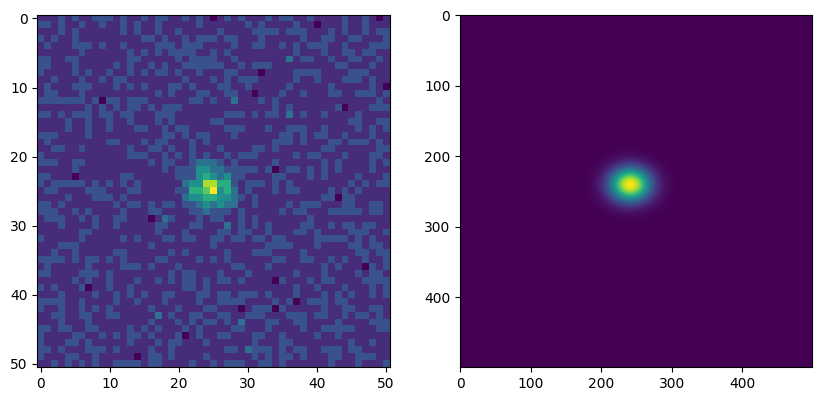

In [4314]:
show_2d_fit(psf_yx, kl_2d)

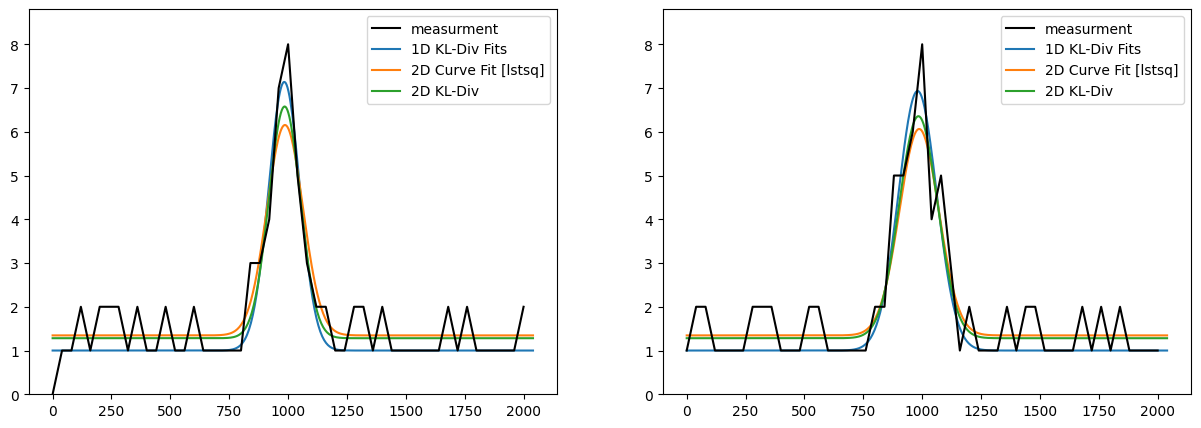

In [4315]:
center = np.array(psf_yx.shape)//2
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(coords_y, psf_yx[:, center[1]], '-', label='measurment', color='k', zorder=10)
# plt.bar(coords_y, psf_yx[:, center[1]], color='k', zorder=10, width=5)
plt.plot(fine_coords_y[:,0], gauss_2d(*params)(fine_coords_y), label="1D KL-Div Fits")
plt.plot(fine_coords_y[:,0], gauss_2d(*popt)(fine_coords_y), label="2D Curve Fit [lstsq]")
plt.plot(fine_coords_y[:,0], gauss_2d(*res.x)(fine_coords_y), label="2D KL-Div")
plt.ylim(y_lim);
plt.legend();
plt.subplot(1,2,2)
plt.plot(coords_x, psf_yx[center[0]], '-', label='measurment', color='k', zorder=10)
# plt.bar(coords_x, psf_yx[center[0]], color='k', zorder=10, width=5)
plt.plot(fine_coords_x[:,1], gauss_2d(*params)(fine_coords_x), label="1D KL-Div Fits")
plt.plot(fine_coords_x[:,1], gauss_2d(*popt)(fine_coords_x), label="2D Curve Fit [lstsq]")
plt.plot(fine_coords_x[:,1], gauss_2d(*res.x)(fine_coords_x), label="2D KL-Div")
plt.ylim(y_lim);
plt.legend();

In [4316]:
from skimage.measure import find_contours

In [4317]:
cc = find_contours(gauss_2d(*params)(fine_coords_yx).reshape(500, 500), level=amp/2 + bg)[0]
cc = cc / 500 * psf_yx.shape[0]

In [4318]:
cv_cc = find_contours(cv_2d, level=popt[0]/2 + popt[1])[0]
cv_cc = cv_cc / 500 * psf_yx.shape[0]

In [4319]:
kl_cc = find_contours(kl_2d, level=res.x[0]/2 + res.x[1])[0]
kl_cc = kl_cc / 500 * psf_yx.shape[0]

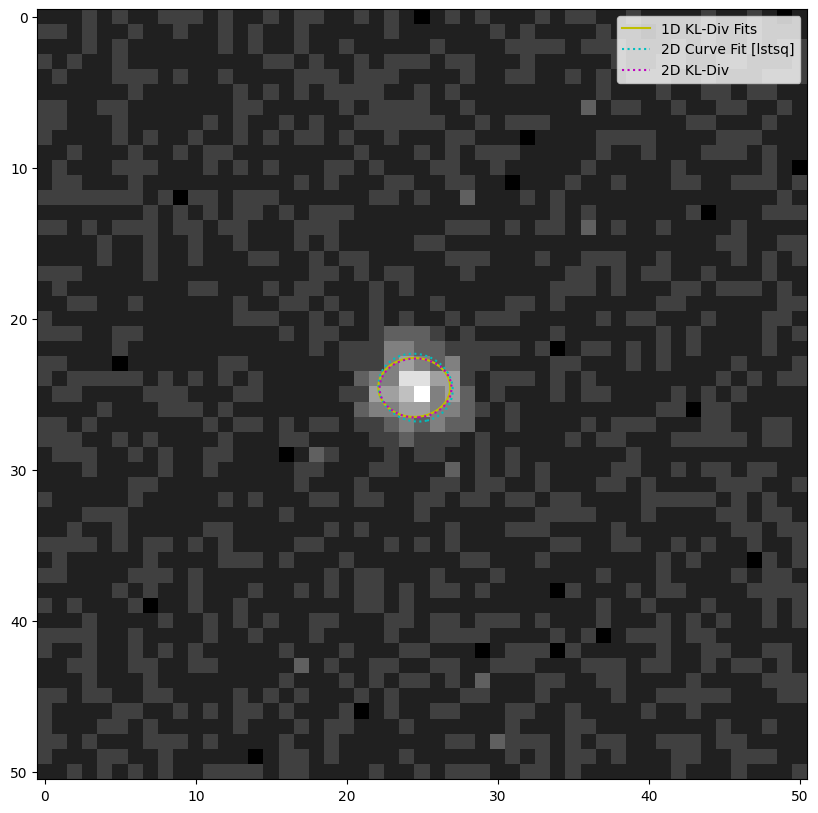

In [4320]:
plt.figure(figsize=(10,10))
plt.imshow(psf_yx, cmap='gray')
plt.plot(cc[:,1], cc[:,0], '-', color='y', label="1D KL-Div Fits")
plt.plot(cv_cc[:,1], cv_cc[:,0], ':', color='c', label="2D Curve Fit [lstsq]")
plt.plot(kl_cc[:,1], kl_cc[:,0], ':', color='m', label="2D KL-Div")
plt.legend()

In [4321]:
cv_2d_fwhm_x = fwhm(np.sqrt(popt[4]))
cv_2d_fwhm_y = fwhm(np.sqrt(popt[6]))

In [4322]:
kld_2d_fwhm_x = fwhm(np.sqrt(res.x[4]))
kld_2d_fwhm_y = fwhm(np.sqrt(res.x[6]))

In [4323]:
print("FWHM X")
print(f"Est. 1D: {est_fwhm_x:4.4f}, {est_fwhm_x/spacing[2]:4.4f}")
print(f"CV.  1D:  {cv_fwhm_x:4.4f}, {cv_fwhm_x/spacing[2]:4.4f}")
print(f"CV.  2D:  {cv_2d_fwhm_x:4.4f}, {cv_2d_fwhm_x/spacing[2]:4.4f}")
print(f"KLD. 1D:  {kld_fwhm_x:4.4f}, {kld_fwhm_x/spacing[2]:4.4f}")
print(f"KLD. 2D:  {kld_2d_fwhm_x:4.4f}, {kld_2d_fwhm_x/spacing[2]:4.4f}")

FWHM X
Est. 1D: 864.7720, 21.6193
CV.  1D:  -197.3281, -4.9332
CV.  2D:  196.9268, 4.9232
KLD. 1D:  190.9475, 4.7737
KLD. 2D:  190.9474, 4.7737


In [4324]:
print("FWHM Y")
print(f"Est. 1D: {est_fwhm_y:4.4f}, {est_fwhm_y/spacing[1]:4.4f}")
print(f"CV.  1D:  {cv_fwhm_y:4.4f}, {cv_fwhm_y/spacing[1]:4.4f}")
print(f"CV.  2D:  {cv_2d_fwhm_y:4.4f}, {cv_2d_fwhm_y/spacing[1]:4.4f}")
print(f"KLD. 1D:  {kld_fwhm_y:4.4f}, {kld_fwhm_y/spacing[1]:4.4f}")
print(f"KLD. 2D:  {kld_2d_fwhm_y:4.4f}, {kld_2d_fwhm_y/spacing[1]:4.4f}")

FWHM Y
Est. 1D: 887.7485, 22.1937
CV.  1D:  -139.5168, -3.4879
CV.  2D:  180.1035, 4.5026
KLD. 1D:  156.3559, 3.9089
KLD. 2D:  156.3582, 3.9090


# 3D

In [4325]:
zz = np.arange(psf.shape[0]) * spacing[0]
yy = np.arange(psf.shape[1]) * spacing[1]
xx = np.arange(psf.shape[2]) * spacing[2]
z, y, x = np.meshgrid(zz, yy, xx, indexing="ij")
coords_zyx = np.stack([z.ravel(), y.ravel(), x.ravel()], -1)

In [4326]:
zz_fine = np.linspace(0, psf.shape[0], 500) * spacing[0]
yy_fine = np.linspace(0, psf.shape[1], 500) * spacing[1]
xx_fine = np.linspace(0, psf.shape[2], 500) * spacing[2]
z_fine, y_fine, x_fine = np.meshgrid(zz_fine, yy_fine, xx_fine, indexing="ij")
fine_coords_zyx = np.stack([z_fine.ravel(), y_fine.ravel(), x_fine.ravel()], -1)

# fine_coords_y = np.stack([yy_fine, [xx_fine[xx_fine.shape[0]//2],]*len(yy_fine)], axis=1)
# fine_coords_x = np.stack([[yy_fine[yy_fine.shape[0]//2],]*len(xx_fine), xx_fine], axis=1)

In [4327]:
def gauss_3d(amp, bg, mu_x, mu_y, mu_z, cxx, cxy, cxz, cyy, cyz, czz):
    def fun(coords):
        cov_inv = np.linalg.inv(np.array([[cxx, cxy, cxz], [cxy, cyy, cyz], [cxz, cyz, czz]]))
        exponent = -0.5 * (
                    cov_inv[0, 0] * (coords[:, 2] - mu_x) ** 2
                    + 2 * cov_inv[0, 1] * (coords[:, 2] - mu_x) * (coords[:, 1] - mu_y)
                    + 2 * cov_inv[0, 2] * (coords[:, 2] - mu_x) * (coords[:, 0] - mu_z)
                    + cov_inv[1, 1] * (coords[:, 1] - mu_y) ** 2
                    + 2 * cov_inv[1, 2] * (coords[:, 1] - mu_y) * (coords[:, 0] - mu_z)
                    + cov_inv[2, 2] * (coords[:, 0] - mu_z) ** 2
                )
        
        return amp * np.exp(exponent) + bg
    return fun

### Curve fit

In [4328]:
from scipy.optimize import curve_fit

In [4329]:
def eval_fun(x, amp, bg, mu_x, mu_y, mu_z, cxx, cxy, cxz, cyy, cyz, czz):
    return gauss_3d(amp=amp, bg=bg, mu_x=mu_x, mu_y=mu_y, mu_z=mu_z, 
                    cxx=cxx, cxy=cxy, cxz=cxz, cyy=cyy, cyz=cyz, czz=czz)(x)

In [4330]:
bg = np.median(psf)
amp = psf.max() - bg

In [4331]:
params = [
        amp, 
        bg, 
        mu_x, 
        mu_y, 
        mu_z,
        (kld_fwhm_x/(2 * np.sqrt(2 * np.log(2))))**2,
        0,
        0,
        (kld_fwhm_y/(2 * np.sqrt(2 * np.log(2))))**2,
        0,
        (kld_fwhm_z/(2 * np.sqrt(2 * np.log(2))))**2,
    ]

In [4332]:
popt, pcov = curve_fit(
    eval_fun,
    coords_zyx,
    psf.ravel(),
    p0=params,
)

In [4333]:
popt

array([ 4.96883341e+00,  1.33675182e+00,  9.82919251e+02,  9.88201139e+02,
        2.07822179e+03,  6.79831414e+03,  2.16664488e+02, -1.45470275e+02,
        7.04965803e+03,  9.32234025e+01,  1.15860247e+05])

In [4334]:
cv_3d = gauss_3d(*popt)(fine_coords_zyx)
cv_3d = cv_3d.reshape((500, 500, 500))

show_2d_fit(psf[psf.shape[0]//2], cv_3d[cv_3d.shape[0]//2])

### Minimize KL-Div

In [4335]:
from scipy.special import kl_div
from scipy.optimize import minimize

def get_objective(coords, measurement):
    def objective(params):

        
        fit = gauss_3d(*params)(coords)
        
        kld = kl_div(fit, measurement)
        kld[np.isinf(kld)] = 0
        
        return np.sum(kld)
    
    return objective

In [4336]:
params

[7.0,
 1.0,
 980.5382703717877,
 983.8645220127208,
 2073.788354940942,
 6575.250837358476,
 0,
 0,
 4408.7253994228595,
 0,
 102978.92562869839]

In [4337]:
res = minimize(get_objective(coords_zyx, psf.ravel()), 
               x0=params,
               method='L-BFGS-B',
               options={'disp': True},
               bounds=[
                   (params[0]*0.5, params[0]*1.5), 
                   (0, params[0]/2), 
                   (params[2] - spacing[2], params[2] + spacing[2]), 
                   (params[3] - spacing[1], params[3] + spacing[1]), 
                   (params[4] - spacing[0], params[4] + spacing[0]), 
                   (params[5]*0.5, params[5]*1.5),
                   (None, None),
                   (None, None),
                   (params[8]*0.5, params[8]*1.5),
                   (None, None),
                   (params[10]*0.5, params[10]*1.5),
               ]
              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26388D+04    |proj g|=  2.50000D+00

At iterate    1    f=  8.97244D+03    |proj g|=  3.61588D+00

At iterate    2    f=  8.97152D+03    |proj g|=  3.61400D+00

At iterate    3    f=  8.97150D+03    |proj g|=  3.61353D+00

At iterate    4    f=  8.97150D+03    |proj g|=  3.61319D+00

At iterate    5    f=  8.97144D+03    |proj g|=  3.60859D+00

At iterate    6    f=  8.97134D+03    |proj g|=  3.59880D+00

At iterate    7    f=  8.97104D+03    |proj g|=  3.56782D+00

At iterate    8    f=  8.97033D+03    |proj g|=  3.49137D+00

At iterate    9    f=  8.96871D+03    |proj g|=  3.30736D+00

At iterate   10    f=  8.96582D+03    |proj g|=  2.95765D+00

At iterate   11    f=  8.96256D+03    |proj g|=  2.23210D+00

At iterate   12    f=  8.96082D+03    |proj g|=  2.22811D+00

At iterate   13    f=  8.9

In [4338]:
kl_3d = gauss_3d(*res.x)(fine_coords_zyx)
kl_3d = kl_3d.reshape((500, 500, 500))

In [4339]:
cv_3d_fwhm_x = fwhm(np.sqrt(popt[5]))
cv_3d_fwhm_y = fwhm(np.sqrt(popt[8]))
cv_3d_fwhm_z = fwhm(np.sqrt(popt[10]))

show_2d_fit(psf[psf.shape[0]//2], kl_3d[kl_3d.shape[0]//2])

In [4368]:
kld_3d_fwhm_x = fwhm(np.sqrt(res.x[5]))
kld_3d_fwhm_y = fwhm(np.sqrt(res.x[8]))
kld_3d_fwhm_z = fwhm(np.sqrt(res.x[10]))

In [4369]:
from skimage.measure import find_contours

In [4370]:
zz_fine = np.linspace(0, psf.shape[0], 500) * spacing[0]
yy_fine = np.linspace(0, psf.shape[1], 500) * spacing[1]
xx_fine = np.linspace(0, psf.shape[2], 500) * spacing[2]
z_fine, y_fine, x_fine = np.meshgrid(zz_fine, yy_fine, xx_fine, indexing="ij")
fine_coords_zyx = np.stack([z_fine.ravel(), y_fine.ravel(), x_fine.ravel()], -1)

In [4371]:
fc_z_plane = np.stack([
    (np.ones((1, 500, 500)) * psf.shape[0]//2 * spacing[0]).ravel(),
    y_fine[:1].ravel(),
    x_fine[:1].ravel()
],
-1
)

In [4372]:
fc_y_plane = np.stack([
    z_fine[:, :1].ravel(),
    (np.ones((500, 1, 500)) * psf.shape[1]//2 * spacing[1]).ravel(),
    x_fine[:, :1].ravel()
],
-1
)

In [4373]:
fc_x_plane = np.stack([
    z_fine[:, :, :1].ravel(),
    y_fine[:, :, :1].ravel(),
    (np.ones((500, 500, 1)) * psf.shape[1]//2 * spacing[2]).ravel(),
],
-1
)

In [4374]:
base_z_plane = gauss_3d(*params)(fc_z_plane).reshape(500, 500)
cv_z_plane = gauss_3d(*popt)(fc_z_plane).reshape(500, 500)
kl_z_plane = gauss_3d(*res.x)(fc_z_plane).reshape(500, 500)

In [4375]:
base_y_plane = gauss_3d(*params)(fc_y_plane).reshape(500, 500)
cv_y_plane = gauss_3d(*popt)(fc_y_plane).reshape(500, 500)
kl_y_plane = gauss_3d(*res.x)(fc_y_plane).reshape(500, 500)

In [4376]:
base_x_plane = gauss_3d(*params)(fc_x_plane).reshape(500, 500)
cv_x_plane = gauss_3d(*popt)(fc_x_plane).reshape(500, 500)
kl_x_plane = gauss_3d(*res.x)(fc_x_plane).reshape(500, 500)

In [4377]:
cv2d_z_plane = gauss_2d(*cv_2d_params)(fine_coords_yx).reshape(500, 500)

In [4378]:
kl2d_z_plane = gauss_2d(*kl_2d_params)(fine_coords_yx).reshape(500, 500)

In [4379]:
base_z_contours = find_contours(base_z_plane, level=params[0]/2 + params[1])[0]
base_z_contours = base_z_contours / 500 * psf.shape[1]

In [4380]:
cv2d_z_convtours = find_contours(cv2d_z_plane, level=cv_2d_params[0]/2 + cv_2d_params[1])[0]
cv2d_z_convtours = cv2d_z_convtours / 500 * psf.shape[1]

In [4381]:
kl2d_z_convtours = find_contours(kl2d_z_plane, level=kl_2d_params[0]/2 + kl_2d_params[1])[0]
kl2d_z_convtours = kl2d_z_convtours / 500 * psf.shape[1]

In [4382]:
base_y_contours = find_contours(base_y_plane, level=params[0]/2 + params[1])[0]
base_y_contours = base_y_contours / 500 * psf.shape[1]

In [4383]:
base_x_contours = find_contours(base_x_plane, level=params[0]/2 + params[1])[0]
base_x_contours = base_x_contours / 500 * psf.shape[1]

In [4384]:
cv_z_contours = find_contours(cv_z_plane, level=popt[0]/2 + popt[1])[0]
cv_z_contours = cv_z_contours / 500 * psf.shape[1]

In [4385]:
cv_y_contours = find_contours(cv_y_plane, level=popt[0]/2 + popt[1])[0]
cv_y_contours = cv_y_contours / 500 * psf.shape[1]

In [4386]:
cv_x_contours = find_contours(cv_x_plane, level=popt[0]/2 + popt[1])[0]
cv_x_contours = cv_x_contours / 500 * psf.shape[1]

In [4387]:
kl_z_contours = find_contours(kl_z_plane, level=res.x[0]/2 + res.x[1])[0]
kl_z_contours = kl_z_contours / 500 * psf.shape[1]

In [4388]:
kl_y_contours = find_contours(kl_y_plane, level=res.x[0]/2 + res.x[1])[0]
kl_y_contours = kl_y_contours / 500 * psf.shape[1]

In [4389]:
kl_x_contours = find_contours(kl_x_plane, level=res.x[0]/2 + res.x[1])[0]
kl_x_contours = kl_x_contours / 500 * psf.shape[1]

In [4390]:
from matplotlib_scalebar.scalebar import ScaleBar
def get_ellipsoid(cov, spacing=spacing):
    bias=0
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)

    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    x, y, z = (cov @ np.stack((x, y, z), 0).reshape(3, -1) + bias).reshape(3, *x.shape)
    return x/spacing[2], y/spacing[1], z/spacing[0]

In [4391]:
xy_spacing = spacing[1]
z_spacing = spacing[0]

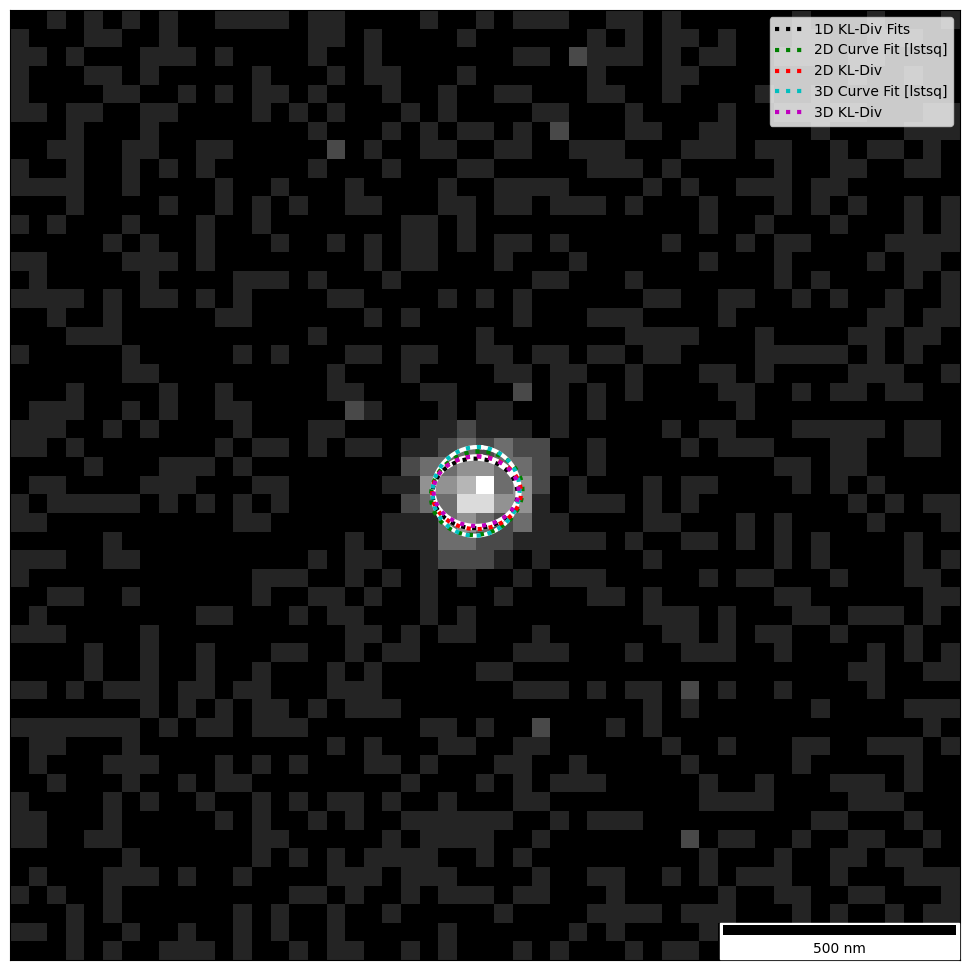

In [4392]:
vmin, vmax = np.quantile(psf, 0.03), np.quantile(psf, 1)

extent = [0, psf.shape[1], 0, psf.shape[2]]
fig = plt.figure(figsize=(10,10))

ax_xy = fig.add_axes([0.025, 0.025, 0.95, 0.95])

scalebar = ScaleBar(xy_spacing, "nm", fixed_value=500, location="lower " "right")
ax_xy.add_artist(scalebar)
ax_xy.set_xticks([])
ax_xy.set_yticks([])
ax_xy.imshow(
    psf[psf.shape[0]//2],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           '-', color='white', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           ':', color='black', linewidth=3, label="1D KL-Div Fits")
ax_xy.plot(cv2d_z_convtours[:,1] + 0.5, cv2d_z_convtours[:,0] + 0.5, 
           ':', color='green', linewidth=3, label="2D Curve Fit [lstsq]")
ax_xy.plot(kl2d_z_convtours[:,1] + 0.5, kl2d_z_convtours[:,0] + 0.5, 
           ':', color='red', linewidth=3, label="2D KL-Div")
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           ':', color='c', linewidth=3, label="3D Curve Fit [lstsq]")
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           ':', color='m', linewidth=3, label="3D KL-Div")
ax_xy.legend()

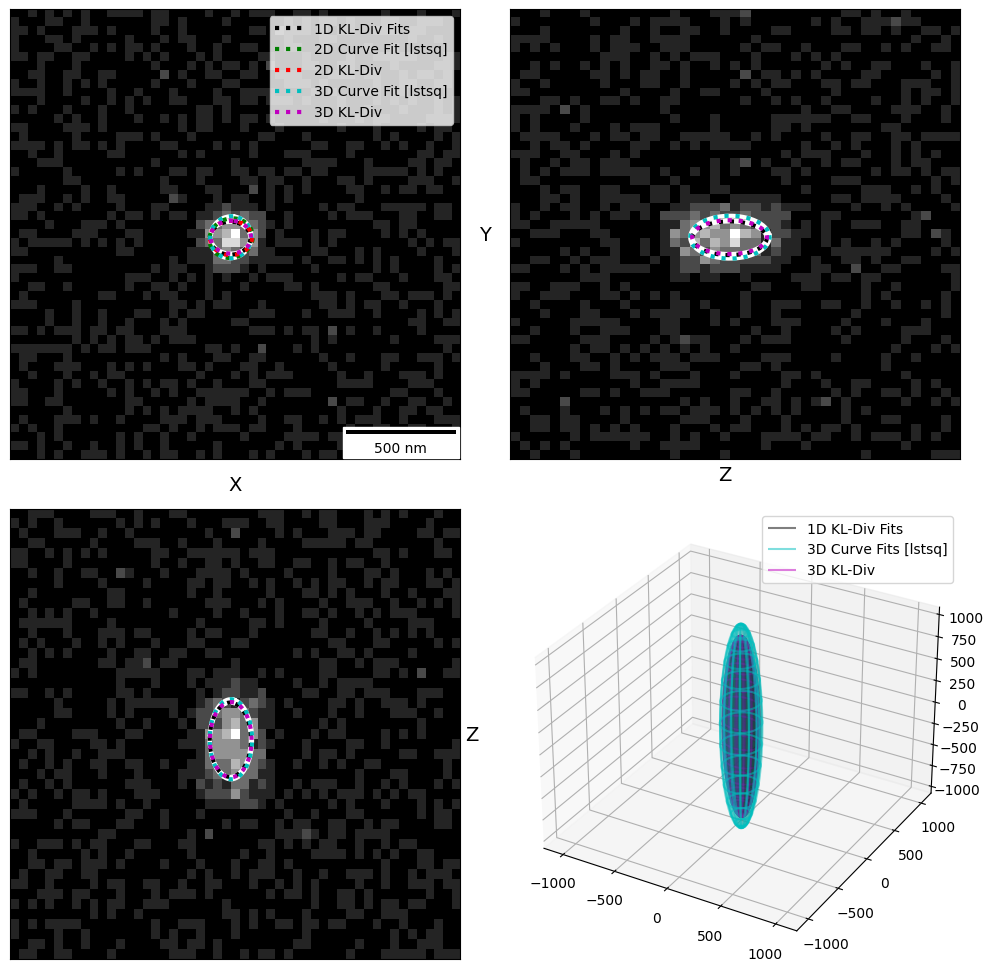

In [4393]:
vmin, vmax = np.quantile(psf, 0.03), np.quantile(psf, 1)

extent = [0, psf.shape[1], 0, psf.shape[2]]

fig = plt.figure(figsize=(10, 10))

ax_xy = fig.add_axes([0.025, 0.525, 0.45, 0.45])
ax_yz = fig.add_axes([0.525, 0.525, 0.45, 0.45])
ax_zx = fig.add_axes([0.025, 0.025, 0.45, 0.45])

ax_X = fig.add_axes([0.24, 0.49, 0.02, 0.02])
ax_X.text(0.5, 0.5, "X", fontsize=14, ha="center", va="center")
ax_X.axis("off")
ax_Y = fig.add_axes([0.49, 0.74, 0.02, 0.02])
ax_Y.text(0.5, 0.5, "Y", fontsize=14, ha="center", va="center")
ax_Y.axis("off")
ax_Z = fig.add_axes([0.477, 0.24, 0.02, 0.02])
ax_Z.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z.axis("off")
ax_Z1 = fig.add_axes([0.73, 0.50, 0.02, 0.02])
ax_Z1.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z1.axis("off")

scalebar = ScaleBar(xy_spacing, "nm", fixed_value=500, location="lower " "right")
ax_xy.add_artist(scalebar)
ax_xy.set_xticks([])
ax_xy.set_yticks([])
ax_xy.imshow(
    psf[psf.shape[0]//2],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           '-', color='white', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           ':', color='black', linewidth=3, label="1D KL-Div Fits")
ax_xy.plot(cv2d_z_convtours[:,1] + 0.5, cv2d_z_convtours[:,0] + 0.5, 
           ':', color='green', linewidth=3, label="2D Curve Fit [lstsq]")
ax_xy.plot(kl2d_z_convtours[:,1] + 0.5, kl2d_z_convtours[:,0] + 0.5, 
           ':', color='red', linewidth=3, label="2D KL-Div")
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           ':', color='c', linewidth=3, label="3D Curve Fit [lstsq]")
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           ':', color='m', linewidth=3, label="3D KL-Div")
ax_xy.legend()

ax_zx.set_xticks([])
ax_zx.set_yticks([])
ax_zx.imshow(
    psf[:, psf.shape[1]//2],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           '-', color='white', linewidth=3)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='black', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='c', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           ':', color='m', linewidth=3)

ax_yz.set_xticks([])
ax_yz.set_yticks([])
ax_yz.imshow(
    psf[:, :, psf.shape[2]//2].T,
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           '-', color='white', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           ':', color='black', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           ':', color='c', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           ':', color='m', linewidth=3)


ax_3D = fig.add_axes(
        [0.525, 0.025, 0.45, 0.45], projection="3d", computed_zorder=True
    )

base_ell = get_ellipsoid([[params[5], 0, 0], [0, params[8], 0], [0, 0, params[10]]], spacing)
ax_3D.plot_surface(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5)
ax_3D.plot_wireframe(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5, label="1D KL-Div Fits")

cv_ell = get_ellipsoid([[popt[5], popt[6], popt[7]], [popt[6], popt[8], popt[9]], [popt[7], popt[9], popt[10]]], spacing)
ax_3D.plot_surface(*cv_ell, rstride=1, cstride=1, color='c', antialiased=True,
               alpha=0.25)
ax_3D.plot_wireframe(*cv_ell, rstride=2, cstride=2, color='c', antialiased=True,
               alpha=0.5, label="3D Curve Fits [lstsq]")

kl_ell = get_ellipsoid([[res.x[5], res.x[6], res.x[7]], [res.x[6], res.x[8], res.x[9]], [res.x[7], res.x[9], res.x[10]]], spacing)
ax_3D.plot_wireframe(*kl_ell, rstride=2, cstride=2, color='m', antialiased=True,
               alpha=0.5, label="3D KL-Div")


bbox_min = np.min([*kl_ell])
bbox_max = np.max([*kl_ell])
ax_3D.auto_scale_xyz([bbox_min, bbox_max], [bbox_min, bbox_max], [bbox_min, bbox_max])
ax_3D.legend()

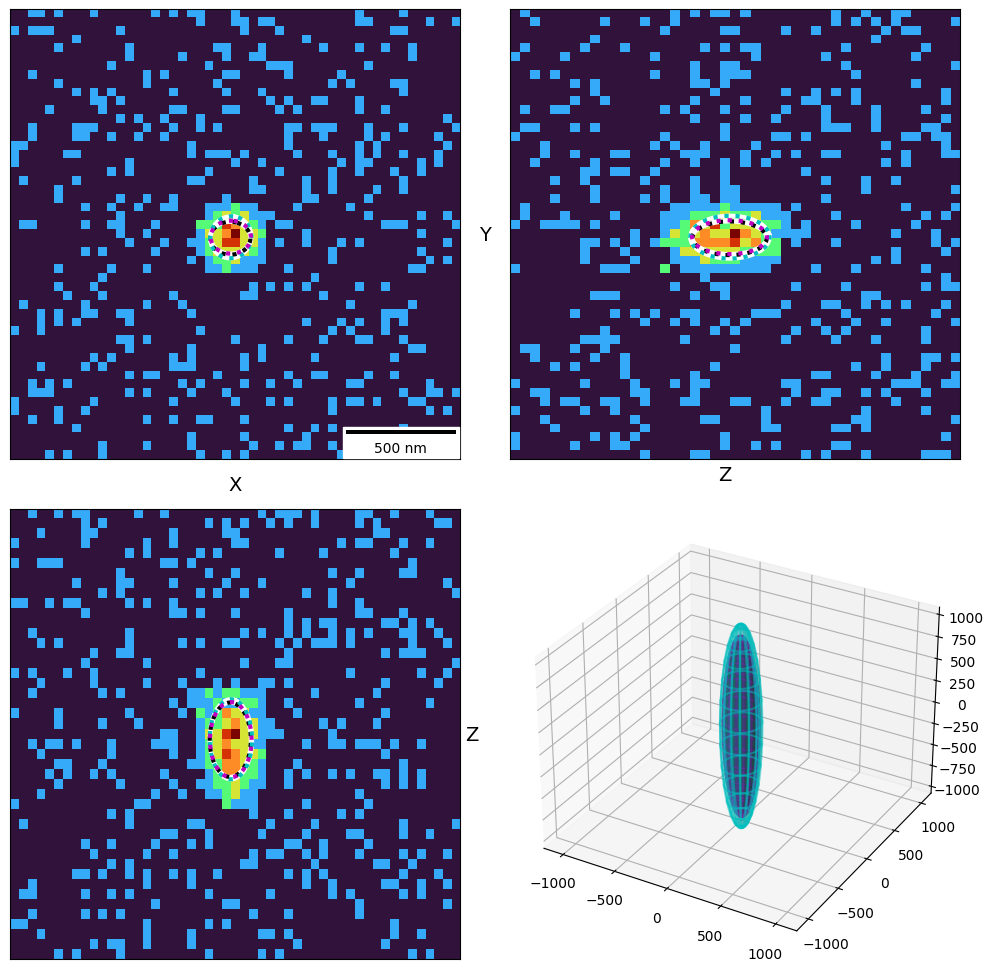

In [4394]:
vmin, vmax = np.quantile(np.sqrt(np.max(psf, axis=0)), 0.03), np.quantile(np.sqrt(np.max(psf, axis=0)), 1)

fig = plt.figure(figsize=(10, 10))

ax_xy = fig.add_axes([0.025, 0.525, 0.45, 0.45])
ax_yz = fig.add_axes([0.525, 0.525, 0.45, 0.45])
ax_zx = fig.add_axes([0.025, 0.025, 0.45, 0.45])

ax_X = fig.add_axes([0.24, 0.49, 0.02, 0.02])
ax_X.text(0.5, 0.5, "X", fontsize=14, ha="center", va="center")
ax_X.axis("off")
ax_Y = fig.add_axes([0.49, 0.74, 0.02, 0.02])
ax_Y.text(0.5, 0.5, "Y", fontsize=14, ha="center", va="center")
ax_Y.axis("off")
ax_Z = fig.add_axes([0.477, 0.24, 0.02, 0.02])
ax_Z.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z.axis("off")
ax_Z1 = fig.add_axes([0.73, 0.50, 0.02, 0.02])
ax_Z1.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z1.axis("off")


scalebar = ScaleBar(xy_spacing, "nm", fixed_value=500, location="lower " "right")
ax_xy.add_artist(scalebar)
ax_xy.set_xticks([])
ax_xy.set_yticks([])
ax_xy.imshow(
    np.sqrt(np.max(psf, axis=0)),
    cmap="turbo",
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           '-', color='white', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           ':', color='black', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           ':', color='c', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           ':', color='m', linewidth=3)

ax_zx.set_xticks([])
ax_zx.set_yticks([])
ax_zx.imshow(
    np.sqrt(np.max(psf, axis=1)),
    cmap="turbo",
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           '-', color='white', linewidth=3)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='black', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='c', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           ':', color='m', linewidth=3)

ax_yz.set_xticks([])
ax_yz.set_yticks([])
ax_yz.imshow(
    np.sqrt(np.max(psf, axis=2)).T,
    cmap="turbo",
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           '-', color='white', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           ':', color='black', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           ':', color='c', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           ':', color='m', linewidth=3)

ax_3D = fig.add_axes(
        [0.525, 0.025, 0.45, 0.45], projection="3d", computed_zorder=True
    )

base_ell = get_ellipsoid([[params[5], 0, 0], [0, params[8], 0], [0, 0, params[10]]], spacing)
ax_3D.plot_surface(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5)
ax_3D.plot_wireframe(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5)

cv_ell = get_ellipsoid([[popt[5], popt[6], popt[7]], [popt[6], popt[8], popt[9]], [popt[7], popt[9], popt[10]]], spacing)
ax_3D.plot_surface(*cv_ell, rstride=1, cstride=1, color='c', antialiased=True,
               alpha=0.25)
ax_3D.plot_wireframe(*cv_ell, rstride=2, cstride=2, color='c', antialiased=True,
               alpha=0.5)

kl_ell = get_ellipsoid([[res.x[5], res.x[6], res.x[7]], [res.x[6], res.x[8], res.x[9]], [res.x[7], res.x[9], res.x[10]]], spacing)
ax_3D.plot_wireframe(*kl_ell, rstride=2, cstride=2, color='m', antialiased=True,
               alpha=0.5)


bbox_min = np.min([*kl_ell])
bbox_max = np.max([*kl_ell])
ax_3D.auto_scale_xyz([bbox_min, bbox_max], [bbox_min, bbox_max], [bbox_min, bbox_max])

In [4395]:
cv_3d_cov = np.array(
    [
        [popt[5], popt[6], popt[7]],
        [popt[6], popt[8], popt[9]],
        [popt[7], popt[9], popt[10]]
    ]
)

In [4222]:
kl_3d_cov = np.array(
    [
        [res.x[5], res.x[6], res.x[7]],
        [res.x[6], res.x[8], res.x[9]],
        [res.x[7], res.x[9], res.x[10]]
    ]
)

In [4223]:
pc = np.sort(np.sqrt(np.linalg.eigvals(cv_3d_cov)))[::-1]
cv_3d_pa1 = fwhm(pc[0])
cv_3d_pa2 = fwhm(pc[1])
cv_3d_pa3 = fwhm(pc[2])

In [4224]:
pc = np.sort(np.sqrt(np.linalg.eigvals(kl_3d_cov)))[::-1]
kl_3d_pa1 = fwhm(pc[0])
kl_3d_pa2 = fwhm(pc[1])
kl_3d_pa3 = fwhm(pc[2])

In [4225]:
print("FWHM X")
print(f"Est. 1D: {est_fwhm_x:9.4f}nm, {est_fwhm_x/spacing[2]:9.4f}px")
print(f"CV.  1D: {cv_fwhm_x:9.4f}nm, {cv_fwhm_x/spacing[2]:9.4f}px")
print(f"CV.  2D: {cv_2d_fwhm_x:9.4f}nm, {cv_2d_fwhm_x/spacing[2]:9.4f}px")
print(f"CV.  3D: {cv_3d_fwhm_x:9.4f}nm, {cv_3d_fwhm_x/spacing[2]:9.4f}px")
print(f"KLD. 1D: {kld_fwhm_x:9.4f}nm, {kld_fwhm_x/spacing[2]:9.4f}px")
print(f"KLD. 2D: {kld_2d_fwhm_x:9.4f}nm, {kld_2d_fwhm_x/spacing[2]:9.4f}px")
print(f"KLD. 3D: {kld_3d_fwhm_x:9.4f}nm, {kld_3d_fwhm_x/spacing[2]:9.4f}px")

FWHM X
Est. 1D:  864.7720nm,   21.6193px
CV.  1D: -197.3281nm,   -4.9332px
CV.  2D:  196.9268nm,    4.9232px
CV.  3D:  194.1594nm,    4.8540px
KLD. 1D:  190.9475nm,    4.7737px
KLD. 2D:  190.9474nm,    4.7737px
KLD. 3D:  190.9474nm,    4.7737px


In [4226]:
print("FWHM Y")
print(f"Est. 1D: {est_fwhm_y:9.4f}nm, {est_fwhm_y/spacing[1]:9.4f}px")
print(f"CV.  1D: {cv_fwhm_y:9.4f}nm, {cv_fwhm_y/spacing[1]:9.4f}px")
print(f"CV.  2D: {cv_2d_fwhm_y:9.4f}nm, {cv_2d_fwhm_y/spacing[1]:9.4f}px")
print(f"CV.  3D: {cv_3d_fwhm_y:9.4f}nm, {cv_3d_fwhm_y/spacing[1]:9.4f}px")
print(f"KLD. 1D: {kld_fwhm_y:9.4f}nm, {kld_fwhm_y/spacing[1]:9.4f}px")
print(f"KLD. 2D: {kld_2d_fwhm_y:9.4f}nm, {kld_2d_fwhm_y/spacing[1]:9.4f}px")
print(f"KLD. 3D: {kld_3d_fwhm_y:9.4f}nm, {kld_3d_fwhm_y/spacing[1]:9.4f}px")

FWHM Y
Est. 1D:  887.7485nm,   22.1937px
CV.  1D: -139.5168nm,   -3.4879px
CV.  2D:  180.1035nm,    4.5026px
CV.  3D:  197.7160nm,    4.9429px
KLD. 1D:  156.3559nm,    3.9089px
KLD. 2D:  156.3582nm,    3.9090px
KLD. 3D:  156.3593nm,    3.9090px


In [4227]:
print("FWHM Z")
print(f"Est. 1D: {est_fwhm_z:9.4f}nm, {est_fwhm_z/spacing[1]:9.4f}px")
print(f"CV.  1D: {cv_fwhm_z:9.4f}nm, {cv_fwhm_z/spacing[1]:9.4f}px")
print(f"CV.  3D: {cv_3d_fwhm_z:9.4f}nm, {cv_3d_fwhm_z/spacing[1]:9.4f}px")
print(f"KLD. 1D: {kld_fwhm_z:9.4f}nm, {kld_fwhm_z/spacing[1]:9.4f}px")
print(f"KLD. 3D: {kld_3d_fwhm_z:9.4f}nm, {kld_3d_fwhm_z/spacing[1]:9.4f}px")

FWHM Z
Est. 1D: 1060.0849nm,   26.5021px
CV.  1D:  794.3962nm,   19.8599px
CV.  3D:  801.5395nm,   20.0385px
KLD. 1D:  755.6695nm,   18.8917px
KLD. 3D:  755.6695nm,   18.8917px


In [4228]:
print(f"CV Fit Principle Axes: ({cv_3d_pa1:9.4f}nm, {cv_3d_pa2:9.4f}nm, {cv_3d_pa3:9.4f}nm)")
print(f"KL-Div Principle Axes: ({kl_3d_pa1:9.4f}nm, {kl_3d_pa2:9.4f}nm, {kl_3d_pa3:9.4f}nm)")

CV Fit Principle Axes: ( 801.5405nm,  199.4584nm,  192.3650nm)
KL-Div Principle Axes: ( 755.6695nm,  190.9474nm,  156.3593nm)


In [4229]:
import pandas as pd

In [4230]:
df = pd.DataFrame(
    {
        "file_name": [file_name],
        "est_1d_fwhm_x": [est_fwhm_x],
        "curvefit_1d_fwhm_x": [cv_fwhm_x],
        "curvefit_2d_fwhm_x": [cv_2d_fwhm_x],
        "curvefit_3d_fwhm_x": [cv_3d_fwhm_x],
        "kldiv_1d_fwhm_x": [kld_fwhm_x],
        "kldiv_2d_fwhm_x": [kld_2d_fwhm_x],
        "kldiv_3d_fwhm_x": [kld_3d_fwhm_x],
        "est_1d_fwhm_y": [est_fwhm_y],
        "curvefit_1d_fwhm_y": [cv_fwhm_y],
        "curvefit_2d_fwhm_y": [cv_2d_fwhm_y],
        "curvefit_3d_fwhm_y": [cv_3d_fwhm_y],
        "kldiv_1d_fwhm_y": [kld_fwhm_y],
        "kldiv_2d_fwhm_y": [kld_2d_fwhm_y],
        "kldiv_3d_fwhm_y": [kld_3d_fwhm_y],
        "est_1d_fwhm_z": [est_fwhm_z],
        "curvefit_1d_fwhm_z": [cv_fwhm_z],
        "curvefit_3d_fwhm_z": [cv_3d_fwhm_z],
        "kldiv_1d_fwhm_z": [kld_fwhm_z],
        "kldiv_3d_fwhm_z": [kld_3d_fwhm_z],
        "curveFit_PA1": [cv_3d_pa1],
        "curveFit_PA2": [cv_3d_pa2],
        "curveFit_PA3": [cv_3d_pa3],
        "kldiv_PA1": [kl_3d_pa1],
        "kldiv_PA2": [kl_3d_pa2],
        "kldiv_PA3": [kl_3d_pa3],
    }
)

In [4231]:
df

,file_name,est_1d_fwhm_x,curvefit_1d_fwhm_x,curvefit_2d_fwhm_x,curvefit_3d_fwhm_x,kldiv_1d_fwhm_x,kldiv_2d_fwhm_x,kldiv_3d_fwhm_x,est_1d_fwhm_y,curvefit_1d_fwhm_y,...,curvefit_1d_fwhm_z,curvefit_3d_fwhm_z,kldiv_1d_fwhm_z,kldiv_3d_fwhm_z,curveFit_PA1,curveFit_PA2,curveFit_PA3,kldiv_PA1,kldiv_PA2,kldiv_PA3
0,/Users/lgelman/Desktop/Singlebeads/LFOV_Dots_L...,864.771977,-197.328099,196.926843,194.159363,190.94746,190.947362,190.947381,887.748487,-139.516765,...,794.39625,801.539536,755.669515,755.669515,801.540482,199.458386,192.365015,755.669515,190.947381,156.359338


In [4085]:
df.to_csv("LFOV_SingleBeads.csv", mode='a', index=False, header=False)